In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import operator

In [2]:
# Helper functions for use later

def naToStr(df, columns):
    '''Convert the na/nan values in a pd dataframe to the string "NaN".'''
    for col in columns:
        df.loc[df[col].isna(), col] = 'NaN'
        
def strToNa(df, columns):
    '''Convert the string values "NaN" back to actual nan'''
    for col in columns:
        df.loc[df[col] == 'NaN', col] = np.nan
        
def oneHotEncoding(df, columns):
    '''Perform one-hot encoding for given columns'''
    d = pd.get_dummies(df[columns], drop_first = True)
    df[d.columns] = d
    df.drop(columns, axis = 1, inplace = True)
        
def imputeMeanWithNA(df, column):
    '''Provides one method to fix missing value for a quantitative column.
    Creates a new 0/1 column indicating whether the original column was na/nan,
    and imputes the mean to the original column where there were na/nan values.
    '''
    df[column + ' NaN'] = df[column].isna().astype(int)
    df.loc[df[column].isna(), column] = df[column].mean()

In [3]:
patient_raw = pd.read_csv('coronavirusdataset/PatientInfo.csv')
patient_raw.head(3).append(patient_raw.tail(3)).T

,0,1,2,3323,3324,3325
patient_id,1000000001,1000000002,1000000003,7000000011,7000000012,7000000013
global_num,2,5,6,NaN,NaN,NaN
sex,male,male,male,male,female,female
birth_year,1964,1987,1964,NaN,NaN,NaN
age,50s,30s,50s,30s,20s,10s
country,Korea,Korea,Korea,Korea,Korea,China
province,Seoul,Seoul,Seoul,Jeju-do,Jeju-do,Jeju-do
city,Gangseo-gu,Jungnang-gu,Jongno-gu,Jeju-do,Jeju-do,Jeju-do
disease,NaN,NaN,NaN,NaN,NaN,NaN
infection_case,overseas inflow,overseas inflow,contact with patient,contact with patient,overseas inflow,overseas inflow


# EDA

In [4]:
print('Number of confirmed cases:', patient_raw.shape[0])

Number of confirmed cases: 3326


In [5]:
patient_raw['state'].value_counts()

released    1637
isolated    1622
deceased      67
Name: state, dtype: int64

## Age

In [6]:
patient_raw['birth_year'].isna().sum()

437

In [7]:
patient_raw['actual_age'] = 2020 - patient_raw['birth_year']

D:\ProgramData\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
D:\ProgramData\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


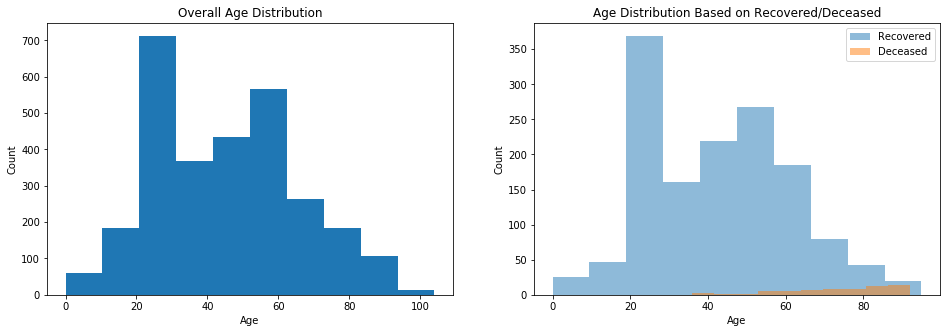

In [8]:
plt.figure(figsize = (16, 5))

plt.subplot(1, 2, 1)
plt.hist(patient_raw['actual_age'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Overall Age Distribution')

plt.subplot(1, 2, 2)
plt.hist(patient_raw['actual_age'][patient_raw['state'] == 'released'], alpha = 0.5)
plt.hist(patient_raw['actual_age'][patient_raw['state'] == 'deceased'], alpha = 0.5)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution Based on Recovered/Deceased')
plt.legend(['Recovered', 'Deceased'])

## Gender

In [9]:
print('Unique gender values:', patient_raw.sex.unique())
print('Number of nan values:', patient_raw.sex.isna().sum())

Unique gender values: ['male' 'female' nan]
Number of nan values: 66


In [10]:
gender_dis = patient_raw[['patient_id', 'sex']].groupby('sex', as_index=False).count()
gender_dis.columns = ['gender', 'confirmed']
gender_dis

,gender,confirmed
0,female,1831
1,male,1429


0.019619500594530322


"\nplt.subplot(1, 2, 2)\nplt.hist(patient_raw[patient_raw['sex'] == 'male']['state'], alpha = 0.5)\nplt.hist(patient_raw[patient_raw['sex'] == 'female']['state'], alpha = 0.5)\nplt.ylabel('Count')\nplt.title('Distribution of Patient_Status based on Gender')\nplt.legend(['Male', 'Female'])\n"

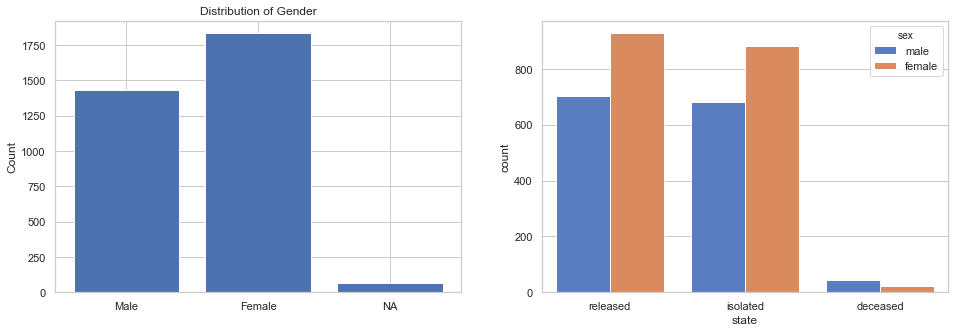

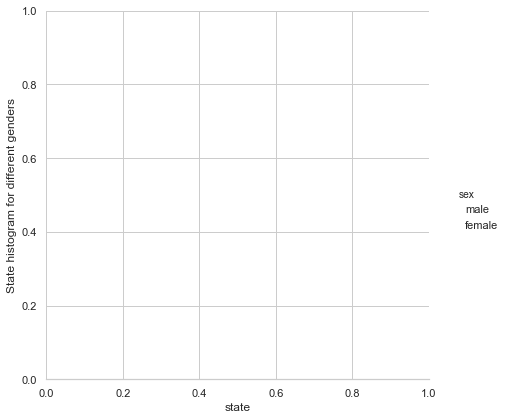

In [33]:
genderMale = np.sum(patient_raw['sex'] == 'male')
genderFemale = np.sum(patient_raw['sex'] == 'female')
genderNA = np.sum(patient_raw['sex'].isna())
print(genderNA/3364)

fig, ax = plt.subplots(1, 2, figsize = (16, 5))

plt.subplot(1, 2, 1)
plt.bar(['Male', 'Female', 'NA'], [genderMale, genderFemale, genderNA])
plt.ylabel('Count')
plt.title('Distribution of Gender')

sns.set(style="whitegrid")
g = sns.catplot(x="state", kind="count", hue="sex", data=patient_raw,
                height=6, palette="muted", ax = ax[1])
g.despine(left=True)
g.set_ylabels("State histogram for different genders")

'''
plt.subplot(1, 2, 2)
plt.hist(patient_raw[patient_raw['sex'] == 'male']['state'], alpha = 0.5)
plt.hist(patient_raw[patient_raw['sex'] == 'female']['state'], alpha = 0.5)
plt.ylabel('Count')
plt.title('Distribution of Patient_Status based on Gender')
plt.legend(['Male', 'Female'])
'''

## Infection Order

- 1 = not infected by other patients in S. Korea
- 2 = infected by the 1st-order patient
- and so forth

In [12]:
patient_raw['infection_order'].value_counts()

1.0    11
2.0     8
3.0     6
5.0     3
4.0     2
6.0     1
Name: infection_order, dtype: int64

## Number of contacts

- 0 = no contact with other patients
- 1 = contacting (and possibly infecting) 1 other person
- and so forth

In [13]:
patient_raw['contact_number'].value_counts()

2.0      81
3.0      70
1.0      67
0.0      64
5.0      36
         ..
20.0      1
84.0      1
174.0     1
32.0      1
75.0      1
Name: contact_number, Length: 77, dtype: int64

The number of values is too small to get a meaningful insight

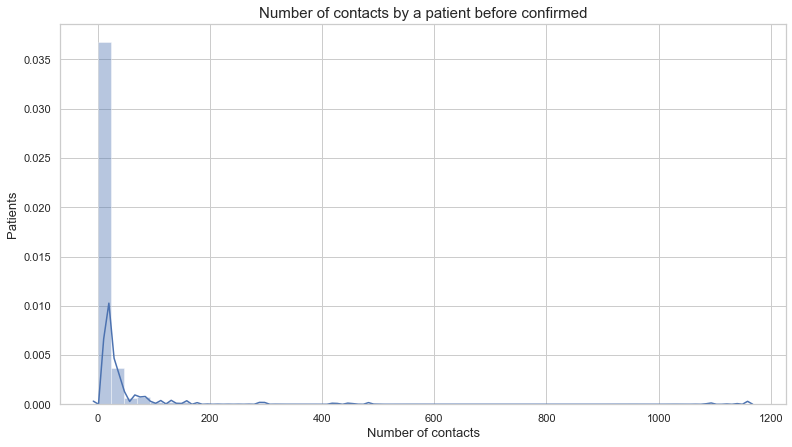

In [14]:
fig, ax = plt.subplots(figsize=(13, 7))
plt.title('Number of contacts by a patient before confirmed', fontsize=15)
sns.distplot(patient_raw['contact_number'].dropna())
ax.set_xlabel('Number of contacts', size=13)
ax.set_ylabel('Patients', size=13)
plt.show()

# Anonymity and Privacy

## K anonymity

In [15]:
patient_raw.columns

Index(['patient_id', 'global_num', 'sex', 'birth_year', 'age', 'country',
       'province', 'city', 'disease', 'infection_case', 'infection_order',
       'infected_by', 'contact_number', 'symptom_onset_date', 'confirmed_date',
       'released_date', 'deceased_date', 'state', 'actual_age'],
      dtype='object')

Quasi-identifiers:
    
- sex
- birth_year
- age (duplicate with birth year)
- province
- city

Here we don't take confirmed_date, released_date and deceased_date as quasi-identifiers because individuals' activity is not supposed by be publicly known.

In [16]:
def k_anonymous(patient_raw, cs = ['sex', 'birth_year', 'province', 'city']):
    dfKAnon = patient_raw.copy()
    naToStr(dfKAnon, dfKAnon.columns)

    kAnonDict = {}
    for i1 in range(len(dfKAnon)):
        row = dfKAnon.iloc[i1]
        key = []
        for c in cs:
            key.append(row[c])
        key = tuple(key)
        if key not in kAnonDict:
            kAnonDict[key] = 0
        kAnonDict[key] += 1
        
    sortedKAnonDict = sorted(kAnonDict.items(), key = operator.itemgetter(1))
    
    kCounts = {}
    for key, value in sortedKAnonDict:
        if value not in kCounts:
            kCounts[value] = 0
        kCounts[value] += 1
    return sortedKAnonDict, kCounts, kAnonDict

In [17]:
sortedKAnonDict, kCounts, _ = k_anonymous(patient_raw, cs = ['sex', 'birth_year', 'province', 'city'])

In [18]:
sortedKAnonDict[:10]

[(('male', 1964.0, 'Seoul', 'Gangseo-gu'), 1),
 (('male', 1987.0, 'Seoul', 'Jungnang-gu'), 1),
 (('male', 1964.0, 'Seoul', 'Jongno-gu'), 1),
 (('male', 1991.0, 'Seoul', 'Mapo-gu'), 1),
 (('female', 1992.0, 'Seoul', 'Seongbuk-gu'), 1),
 (('female', 1966.0, 'Seoul', 'Jongno-gu'), 1),
 (('male', 1995.0, 'Seoul', 'Jongno-gu'), 1),
 (('male', 1983.0, 'Seoul', 'Songpa-gu'), 1),
 (('female', 1962.0, 'Seoul', 'Seodaemun-gu'), 1),
 (('male', 1938.0, 'Seoul', 'Jongno-gu'), 1)]

In [19]:
kCounts[1], kCounts[2], kCounts[3], kCounts[4], kCounts[5]

(1687, 262, 64, 32, 14)

Considering we only have 3300 samples, more than half of samples are unique, which is sure to be "unsafe"

## Fix k anonymity

### Generalize birth year to age period

In [20]:
sortedKAnonDict, kCounts, _ = k_anonymous(patient_raw, cs = ['sex', 'age', 'province', 'city'])

In [21]:
sortedKAnonDict[:10]

[(('male', '30s', 'Seoul', 'Jungnang-gu'), 1),
 (('male', '50s', 'Seoul', 'Jongno-gu'), 1),
 (('female', '50s', 'Seoul', 'Jongno-gu'), 1),
 (('female', '60s', 'Seoul', 'Jongno-gu'), 1),
 (('male', '70s', 'Seoul', 'Seongdong-gu'), 1),
 (('female', '70s', 'Seoul', 'Seongdong-gu'), 1),
 (('male', '50s', 'Seoul', 'Songpa-gu'), 1),
 (('female', '70s', 'Seoul', 'Geumcheon-gu'), 1),
 (('male', '60s', 'Seoul', 'Dongjak-gu'), 1),
 (('male', '40s', 'Seoul', 'Songpa-gu'), 1)]

In [22]:
kCounts[1], kCounts[2], kCounts[3], kCounts[4], kCounts[5]

(567, 217, 118, 71, 34)

We reduce half but still many unique samples.

We notice this can happen when that area (maybe that city), only one male with under certain age period is infected with the flu.

### What if we only publish province?(generalize city to province)

In [23]:
sortedKAnonDict, kCounts,_ = k_anonymous(patient_raw, cs = ['sex', 'age', 'province'])
kCounts[1], kCounts[2], kCounts[3], kCounts[4], kCounts[5]

(52, 29, 29, 21, 14)

We can see that by only publishing provicing we hugely reduces the number of unique samples.

Here we have multiple choice to achieve 3-anonymity:

- Use ['sex', 'age', 'province', 'city'] and then suppression
- Use ['sex', 'age', 'province'] and then suppression

In [24]:
_, _ , KAnonDict_small= k_anonymous(patient_raw, cs = ['sex', 'age', 'province'])
_,_ , KAnonDict_big = k_anonymous(patient_raw, cs = ['sex', 'age', 'province', 'city'])

In [25]:
smallDF = patient_raw.copy()
bigDF = patient_raw.copy()

for key, value in KAnonDict_small.items():
    sex, age, province = key
    indices = ~((smallDF['age'] == age) & (smallDF['sex'] == sex) & (smallDF['province'] == province))
    if value <= 3:
        smallDF = smallDF[indices]

for key, value in KAnonDict_big.items():
    sex, age, province, city = key
    indices = ~((bigDF['age'] == age) & (bigDF['sex'] == sex) & (bigDF['province'] == province) & (bigDF['city'] == city))
    if value <= 3:
        bigDF = bigDF[indices]

## Prediction

For this dataset it is nearly impossible to predict whether the patient will die or recover: the dataset is so biased. This is partly due to the sampling of individual data. But mainly due to the death rate in south korea. In south korea the death rate is really low.

To compare the performance before and after manupulation, here I predict the gap between confirm and release date.

In [26]:
def linear_reg(dataset, i):
    df = dataset.copy()
    df['released_date'] = pd.to_datetime(df['released_date'])
    df['confirmed_date'] = pd.to_datetime(df['confirmed_date'])
    df['timediff'] = (df['released_date'] - df['confirmed_date']).dt.days
    Xnew = df
    Xnew = Xnew[Xnew['timediff'].isna() == False]
    print(Xnew.shape)
    
    if i == 0: # original
        numerical_cols =  ['contact_number', 'birth_year']
        cat_cols = ['sex', 'age', 'country', 'province', 'city', 'infection_case']
    if i == 1: # small
        numerical_cols =  ['contact_number']
        cat_cols = ['sex', 'age', 'country', 'province', 'infection_case']
    if i == 2: # big
        numerical_cols =  ['contact_number']
        cat_cols = ['sex', 'age', 'country', 'province', 'city', 'infection_case']
        
    X = Xnew[numerical_cols + cat_cols]
    
    if i == 0:
        imputeMeanWithNA(X, 'birth_year')
        
    imputeMeanWithNA(X, 'contact_number')
    naToStr(X, cat_cols)
    oneHotEncoding(X, cat_cols)
    y = Xnew['timediff']
    
    def predmodel(X, y):
        def testTrain(X, y):
            return train_test_split(X, y, test_size = 0.3, random_state = 42)

        X_train, X_test, y_train, y_test = testTrain(X, y)
        model = LinearRegression().fit(X_train, y_train)
        trainScore = model.score(X_train, y_train)
        testScore = model.score(X_test, y_test)
        return trainScore, testScore

    trainScore, testScore = predmodel(X, y)
    print('Train accuracy:', trainScore.round(3))
    print('Test accuracy:', testScore.round(3))
    return trainScore, testScore

In [27]:
datasets = [patient_raw, smallDF, bigDF]
names = ['original', 'sex + age + province + suppress', 'sex + age + province + city + suppress']

for i, dataset in enumerate(datasets):
    print("================================================")
    print(names[i])
    linear_reg(dataset, i)
    print("================================================\n\n")

original
(1218, 20)
Train accuracy: 0.229
Test accuracy: 0.036


sex + age + province + suppress
(1136, 20)
Train accuracy: 0.164
Test accuracy: 0.101


sex + age + province + city + suppress
(872, 20)


D:\ProgramData\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\ProgramData\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
D:\ProgramData\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

Train accuracy: 0.155
Test accuracy: 0.009


